In [1]:
from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristicCopy1 import NumericHeuristic5
from pct.tree.splitter.splitterCopy2 import Splitter
from pct.tree.treeCopy2 import Tree

In [2]:
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import math
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df,threshold_interactions_df_plus, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df

my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)

def load_user_item_matrix(filepath):
    data = []

    with open(filepath, 'r') as f:
        while True:
            user_line = f.readline()
            if not user_line:
                break

            user_line = user_line.strip()
            if '|' not in user_line:
                continue

            user_id, num_ratings = user_line.split('|')
            user_id = int(user_id)
            num_ratings = int(num_ratings)

            for _ in range(num_ratings):
                item_line = f.readline().strip()
                parts = item_line.split('\t')
                if len(parts) < 2:
                    continue
                item_id, score = parts[0], parts[1]
                data.append([user_id, int(item_id), int(score)])

    df = pd.DataFrame(data, columns=['user_id', 'item_id', 'rating'])
    return df


In [9]:

def safe_int(x):
    return int(x) if x != 'None' else 0


def load_track_data(filepath):
    track_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            track_id = safe_int(parts[0])
            album_id = safe_int(parts[1])
            artist_id = safe_int(parts[2])
            genre_ids = [safe_int(g) for g in parts[3:]] if len(parts) > 3 else []
            track_data.append([track_id, album_id, artist_id, genre_ids])
    return pd.DataFrame(track_data, columns=['track_id', 'album_id', 'artist_id', 'genre_ids'])

def load_album_data(filepath):
    album_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('|')
            album_id = safe_int(parts[0])
            artist_id = safe_int(parts[1])
            genre_ids = [safe_int(g) for g in parts[2:]] if len(parts) > 2 else []
            album_data.append([album_id, artist_id, genre_ids])
    return pd.DataFrame(album_data, columns=['album_id', 'artist_id', 'genre_ids'])


# read artistData2
def load_artist_data(filepath):
    with open(filepath, 'r') as f:
        artist_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(artist_ids, columns=['artist_id'])

# read genreData2
def load_genre_data(filepath):
    with open(filepath, 'r') as f:
        genre_ids = [int(line.strip()) for line in f]
    return pd.DataFrame(genre_ids, columns=['genre_id'])


In [11]:
track_df = load_track_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/trackData2.txt')
track_df

,track_id,album_id,artist_id,genre_ids
0,1,106710,281667,"[214765, 162234, 155788]"
1,2,280977,233685,"[131552, 173467, 48505]"
2,3,38422,219136,"[61215, 201738, 88853]"
3,4,119529,166863,"[17453, 35389]"
4,5,16742,294690,"[61215, 34486, 274088]"
...,...,...,...,...
224036,296100,166516,33011,"[274088, 199606, 88853]"
224037,296101,0,0,[]
224038,296102,153644,289056,"[158282, 139095, 242383]"
224039,296105,68336,6613,[82064]


In [13]:
album_df = load_album_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/albumData2.txt')
album_df

,album_id,artist_id,genre_ids
0,0,0,[214765]
1,6,228091,"[158282, 81520, 242383]"
2,19,85028,[103715]
3,30,16832,[31567]
4,33,26330,"[149962, 209270]"
...,...,...,...
52824,296104,125866,[158282]
52825,296106,221637,"[116130, 9432]"
52826,296107,0,[61215]
52827,296108,93277,[61215]


In [15]:
artist_df = load_artist_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/artistData2.txt')
artist_df

,artist_id
0,16
1,23
2,35
3,40
4,49
...,...
18669,295987
18670,296007
18671,296012
18672,296013


In [17]:
genre_df = load_genre_data('D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/genreData2.txt')
genre_df

,genre_id
0,208
1,315
2,642
3,1075
4,1271
...,...
562,292093
563,293670
564,293688
565,294138


In [19]:
train_path = 'D:/dataset/ydata-ymusic-kddcup-2011-track2/ydata-ymusic-kddcup-2011-track2/trainIdx2.txt'
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
train_df = load_user_item_matrix(train_path)


In [20]:
train_df

,user_id,item_id,rating
0,0,28341,90
1,0,51210,90
2,0,79500,90
3,0,82317,90
4,0,98399,90
...,...,...,...
61944401,249011,270557,90
61944402,249011,273574,90
61944403,249011,286938,90
61944404,249011,287681,80


In [23]:
duplicate_counts = train_df.groupby(['user_id', 'item_id']).size()
duplicates = duplicate_counts[duplicate_counts > 1]

print(f"🔁 Number of duplicated (user_id, item_id) pairs: {len(duplicates)}")
print(duplicates.head())


🔁 Number of duplicated (user_id, item_id) pairs: 0
Series([], dtype: int64)


In [23]:
print(train_df['item_id'].max())      # highest item_id
print(track_df['track_id'].max())     # highest track_id
print(train_df['item_id'].isin(track_df['track_id']).mean())  # proportion to match

print(train_df['item_id'].isin(album_df['album_id']).mean())

print(train_df['item_id'].isin(artist_df['artist_id']).mean())

print(train_df['item_id'].isin(genre_df['genre_id']).mean())



296110
296110
0.4385845107627636
0.1925648621120041
0.3114063600835885
0.05744426704164376


In [23]:
def build_item_metadata(track_df, album_df, artist_df, genre_df):
    rows = []

    # 1. Tracks
    for _, row in track_df.iterrows():
        rows.append({
            'item_id': row['track_id'],
            'item_type': 'track',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 2. Albums
    for _, row in album_df.iterrows():
        rows.append({
            'item_id': row['album_id'],
            'item_type': 'album',
            'artist_id': row['artist_id'],
            'genre_ids': row['genre_ids']
        })

    # 3. Artists
    for artist_id in artist_df['artist_id']:
        rows.append({
            'item_id': artist_id,
            'item_type': 'artist',
            'artist_id': artist_id,
            'genre_ids': 0
        })

    # 4. Genres
    for genre_id in genre_df['genre_id']:
        rows.append({
            'item_id': genre_id,
            'item_type': 'genre',
            'artist_id': 0,
            'genre_ids': [genre_id]
        })

    return pd.DataFrame(rows)

In [25]:
item_meta_df = build_item_metadata(track_df, album_df, artist_df, genre_df)
# only track?artist
#valid_item_ids = set(track_df['track_id'])
# valid_item_ids = set(artist_df['artist_id'])
# item_meta_df = item_meta_df[item_meta_df['item_id'].isin(valid_item_ids)]
# train_with_meta = train_df.merge(item_meta_df, on='item_id', how='inner')

train_with_meta = train_df.merge(item_meta_df, on='item_id', how='inner')

train_with_meta

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,0,28341,90,artist,28341,0
1,9,28341,0,artist,28341,0
2,13,28341,90,artist,28341,0
3,15,28341,90,artist,28341,0
4,20,28341,90,artist,28341,0
...,...,...,...,...,...,...
61944401,225199,29944,83,track,127850,[274161]
61944402,238684,29944,50,track,127850,[274161]
61944403,243157,29944,70,track,127850,[274161]
61944404,243951,29944,30,track,127850,[274161]


In [181]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Step 1: Prepare data
df = train_with_meta.copy()
# drop "album', 'track" items before all processing
df = train_with_meta[~train_with_meta['item_type'].isin(['album', 'track'])].copy()

# Encode user_id and item_id to indices
user_ids = df['user_id'].unique()
item_ids = df['item_id'].unique()

user_id_map = {uid: i for i, uid in enumerate(user_ids)}
item_id_map = {iid: i for i, iid in enumerate(item_ids)}

# Step 2: Create user-item sparse rating matrix manually
row_indices = df['user_id'].map(user_id_map)
col_indices = df['item_id'].map(item_id_map)
ratings = df['rating'].astype(float)

n_users = len(user_ids)
n_items = len(item_ids)

user_item_sparse = csr_matrix((ratings, (row_indices, col_indices)), shape=(n_users, n_items))

# Step 3: Select core users (or choose active users manually)
np.random.seed(7)
core_indices = np.random.choice(n_users, size=5, replace=False)

# Step 4: Compute cosine similarity between core users and all users
sim_matrix = cosine_similarity(user_item_sparse[core_indices], user_item_sparse)
max_sim = sim_matrix.max(axis=0)

# Step 5: Pick top-K most similar users
top_k = 10000
top_user_indices = np.argsort(max_sim)[-top_k:]
sampled_user_ids = user_ids[top_user_indices]

# Step 6: Filter original data
user_filtered_df = df[df['user_id'].isin(sampled_user_ids)]

# Step 7: Summary
print(f"🎯 Sample shape: {user_filtered_df.shape}")
print(f"👤 Users: {user_filtered_df['user_id'].nunique()}, 🎵 Items: {user_filtered_df['item_id'].nunique()}")



🎯 Sample shape: (1423857, 6)
👤 Users: 10000, 🎵 Items: 14264


In [223]:
# top 1000 item
# item_popularity = train_with_meta['item_id'].value_counts()
# top_items = item_popularity.head(1000).index

# popular_data = train_with_meta[train_with_meta['item_id'].isin(top_items)]
# filtered_df = threshold_interactions_df(user_filtered_df,'user_id','item_id',150,200)
filtered_df = threshold_interactions_df_plus(user_filtered_df, min_items_per_user=200, min_artists_per_user=20, min_genres_per_user=10,min_users_per_item=150)

Initial: users = 10000, items = 14264, sparsity = 0.9982%
After item filtering: users = 1623, items = 987, sparsity = 29.1906%
Final: users = 1369, items = 987, sparsity = 29.7651%
unique artists = 885, unique genres = 104


In [225]:
all_user_ids = sorted(filtered_df['user_id'].unique())
warm_users = all_user_ids[:160]
cold_users = all_user_ids[160:]


df_warm = filtered_df[filtered_df['user_id'].isin(warm_users)].copy()
df_cold = filtered_df[filtered_df['user_id'].isin(cold_users)].copy()


In [227]:
matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating"
)


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix(
    df_cold, "user_id", "item_id", "rating"
)


In [188]:
al, train_cold_K, _ = train_test_split(matrix_cold, 1)


X_cold, test_cold, _ = train_test_split(al, 30)

In [190]:
warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
warm_df 

,28341,51210,79500,82317,98399,151565,152077,173467,176858,180487,...,66644,24047,122746,50976,171764,192639,288310,173536,152418,109905
536,0.0,0.0,89.0,0.0,0.0,0.0,50.0,100.0,0.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,90.0,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
758,90.0,0.0,50.0,0.0,50.0,0.0,70.0,90.0,0.0,90.0,...,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
1178,70.0,0.0,90.0,90.0,0.0,0.0,0.0,90.0,80.0,70.0,...,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1191,0.0,0.0,0.0,0.0,0.0,60.0,0.0,30.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
train_copy = train_cold_K.tolil().copy()
cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
cold_df 

,28341,51210,79500,82317,98399,151565,152077,173467,176858,180487,...,66644,24047,122746,50976,171764,192639,288310,173536,152418,109905
24515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
x_df = pd.concat([warm_df, cold_df], ignore_index=False)
x_df

,28341,51210,79500,82317,98399,151565,152077,173467,176858,180487,...,66644,24047,122746,50976,171764,192639,288310,173536,152418,109905
536,0.0,0.0,89.0,0.0,0.0,0.0,50.0,100.0,0.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,90.0,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
758,90.0,0.0,50.0,0.0,50.0,0.0,70.0,90.0,0.0,90.0,...,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
1178,70.0,0.0,90.0,90.0,0.0,0.0,0.0,90.0,80.0,70.0,...,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1191,0.0,0.0,0.0,0.0,0.0,60.0,0.0,30.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
def elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class,
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    iteration=5
):
    """
    Method 2: Retrain tree each round using warm + cold user data.
    Walk i steps for each cold user to reach a node and elicit a new rating.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    algo = SVD()
    trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(trainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (Tree depth = {i+1})")

        # Step 1: Prepare tree training data (warm + updated cold)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)

        tree_model = tree_model_class(max_depth=i+1, min_instances=5)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        # Step 2: Walk tree and elicit a new rating for each cold user
        for u in range(num_users):
            node = tree_model.root
            depth = 0

            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 81:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            if node is None or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0

        # Step 3: Evaluate updated cold user SVD model
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        algo = SVD()
        trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
        algo.fit(trainset)

        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [114]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(tree_model_class, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")
        # Retrain tree using current train_copy
        tree_model = tree_model_class(max_depth=i + 1, min_instances=5)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = tree_model.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating >= 4:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list

In [269]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class=Tree,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)


RMSE: 68.2439
MAE:  64.0220
✅ Baseline evaluation complete.

🔁 Iteration 1/15 (Tree depth = 1)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 68.2431
MAE:  64.0205
✅ Iteration 1 complete.

🔁 Iteration 2/15 (Tree depth = 2)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 68.2429
MAE:  64.0201
✅ Iteration 2 complete.

🔁 Iteration 3/15 (Tree depth = 3)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 68.2426
MAE:  64.0197
✅ Iteration 3 complete.

🔁 Iteration 4/15 (Tree depth = 4)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 68.2422
MAE:  64.0187
✅ Iteration 4 complete.

🔁 Iteration 5/15 (Tree depth = 5)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 68.2418
MAE:  64.0185
✅ Iteration 5 complete.

🔁 Iteration 6/15 (Tree depth = 6)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 68.2417
MAE:  64.0182
✅ Iteration 6 co

([68.24388809908241,
  68.24312798051348,
  68.24288110821989,
  68.24255102521408,
  68.24217177893857,
  68.24183002653707,
  68.24170122970396,
  68.24203131682019,
  68.24172882894048,
  68.24170122970396,
  68.24195929657738,
  68.24170122970396,
  68.24170122970396,
  68.24203131682019,
  68.24170122970396,
  68.24170122970396],
 [64.02195090020025,
  64.02049162113227,
  64.02012940330697,
  64.01965013179966,
  64.01869158878505,
  64.01854537428035,
  64.01821231727774,
  64.01869158878505,
  64.01828672977439,
  64.01821231727774,
  64.01859041489628,
  64.01821231727774,
  64.01821231727774,
  64.01869158878505,
  64.01821231727774,
  64.01821231727774])

In [319]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

elicitation_by_tree_path_retrain_skiped_warm(
    tree_model_class=Tree,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 68.2435
MAE:  64.0214
✅ Baseline evaluation complete.

🔁 Iteration 1/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 68.2430
MAE:  64.0204
✅ Iteration 1 complete.

🔁 Iteration 2/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 68.2429
MAE:  64.0201
✅ Iteration 2 complete.

🔁 Iteration 3/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 68.2426
MAE:  64.0197
✅ Iteration 3 complete.

🔁 Iteration 4/15 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 68.2426
MAE:  64.0197
✅ Iteration 4 complete.

🔁 Iteration 5/15 (skip asked items, walk from root)
I

([68.24351523656121,
  68.24297203143789,
  68.24288110821989,
  68.24257314731562,
  68.24257274205564,
  68.24255102521408,
  68.24255102521408,
  68.24255102521408,
  68.24222094061169,
  68.2420569593203,
  68.24189085441269,
  68.24215803172652,
  68.24189085441269,
  68.24189085441269,
  68.24234823213611,
  68.24219032843737],
 [64.02144620761337,
  64.02036808843555,
  64.02012940330697,
  64.01970992184138,
  64.01970883705819,
  64.01965013179966,
  64.01965013179966,
  64.01965013179966,
  64.01917086029236,
  64.01911506740146,
  64.01869158878505,
  64.01908258357132,
  64.01869158878505,
  64.01869158878505,
  64.01936141217897,
  64.01912807084759])

In [116]:
def i_variance(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matirx.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()
    
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [57]:
def elicitation_np(train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    
    train_copy = (train.tolil()).copy()

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        scores = strategy(train_copy)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [166]:
entropy_0 = elicitation_np(train,test,X_matrix,i_entropy_0,iteration=9,k=10,positive=True)


RMSE: 79.0491
MAE:  77.2960
RMSE: 79.0491
MAE:  77.2960
1
RMSE: 79.0491
MAE:  77.2960
2
RMSE: 79.0491
MAE:  77.2960
3
RMSE: 79.0491
MAE:  77.2960
4
RMSE: 79.0491
MAE:  77.2960
5
RMSE: 79.0491
MAE:  77.2960
6
RMSE: 79.0491
MAE:  77.2960
7
RMSE: 79.0491
MAE:  77.2960
8


In [118]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm, train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [120]:
def flat_baseline_from_elicitation_np_warm(matrix_warm, train, X, test):
    """
    Train a single SVD model using full info: matrix_warm + train + X
    Return RMSE and MAE on test set (Surprise-based).
    """
    #  K + X
    full_train_cold = train.copy().tolil()
    X_copy = X.copy().tolil()
    for u in range(train.shape[0]):
        items = X_copy.getrow(u).nonzero()[1]
        for item in items:
            full_train_cold[u, item] = X[u, item]

    # combine warm and  cold 
    full_matrix = sp.vstack([matrix_warm.tocsr(), full_train_cold.tocsr()])

    #  convert dataframe
    train_df = matrix_to_df_2(full_train_cold, idx_to_rid_cold, idx_to_cid)
    test_df = matrix_to_df(test, idx_to_rid_cold, idx_to_cid)

    # train SVD 
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)

    # Predict on test
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions = algo.test(test_rr.build_testset())
    
    rmse_val = accuracy.rmse(predictions)
    mae_val = accuracy.mae(predictions)

    print(f"[Flat Baseline] RMSE = {rmse_val:.4f}, MAE = {mae_val:.4f}")
    return rmse_val, mae_val


In [122]:
flat = flat_baseline_from_elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    X=X_cold,
    test=test_cold
)


RMSE: 78.7921
MAE:  76.5834
[Flat Baseline] RMSE = 78.7921, MAE = 76.5834


In [124]:
entropy0 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    strategy=i_entropy_0,
    iteration=15,
    k=1,
    positive=False
)


RMSE: 78.7932
MAE:  76.5834
RMSE: 78.7932
MAE:  76.5834
1
RMSE: 78.7932
MAE:  76.5834
2
RMSE: 78.7932
MAE:  76.5834
3
RMSE: 78.7932
MAE:  76.5831
4
RMSE: 78.7932
MAE:  76.5829
5
RMSE: 78.7932
MAE:  76.5829
6
RMSE: 78.7932
MAE:  76.5830
7
RMSE: 78.7932
MAE:  76.5828
8
RMSE: 78.7932
MAE:  76.5829
9
RMSE: 78.7932
MAE:  76.5829
10
RMSE: 78.7932
MAE:  76.5829
11
RMSE: 78.7932
MAE:  76.5829
12
RMSE: 78.7932
MAE:  76.5829
13
RMSE: 78.7932
MAE:  76.5829
14


In [291]:
variance = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    strategy=i_variance,
    iteration=15,
    k=1,
    positive=False
)

RMSE: 68.2434
MAE:  64.0209
RMSE: 68.2434
MAE:  64.0211
1
RMSE: 68.2429
MAE:  64.0202
2
RMSE: 68.2429
MAE:  64.0201
3
RMSE: 68.2430
MAE:  64.0204
4
RMSE: 68.2432
MAE:  64.0207
5
RMSE: 68.2429
MAE:  64.0203
6
RMSE: 68.2429
MAE:  64.0201
7
RMSE: 68.2432
MAE:  64.0207
8
RMSE: 68.2433
MAE:  64.0210
9
RMSE: 68.2431
MAE:  64.0204
10
RMSE: 68.2434
MAE:  64.0210
11
RMSE: 68.2432
MAE:  64.0206
12
RMSE: 68.2431
MAE:  64.0206
13
RMSE: 68.2430
MAE:  64.0203
14


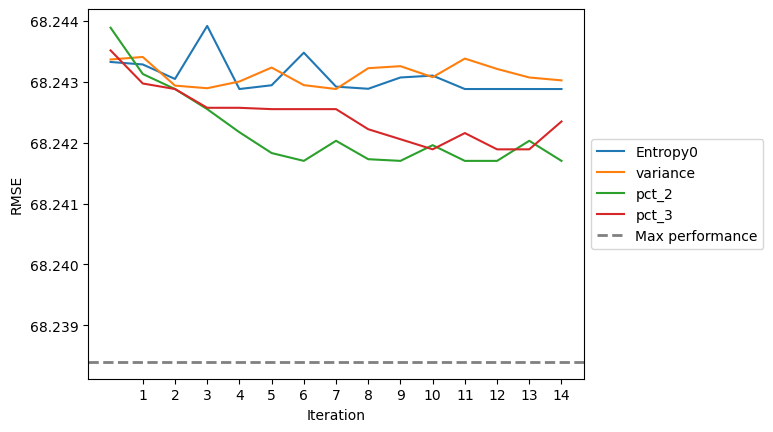

In [323]:
x = np.arange(0,15) 
fig, (ax1) = plt.subplots(1)

baseline_rmse = 68.2384  # Flat baseline RMSE
pct_2 = [68.24388809908241,
  68.24312798051348,
  68.24288110821989,
  68.24255102521408,
  68.24217177893857,
  68.24183002653707,
  68.24170122970396,
  68.24203131682019,
  68.24172882894048,
  68.24170122970396,
  68.24195929657738,
  68.24170122970396,
  68.24170122970396,
  68.24203131682019,
  68.24170122970396]
pct_3 = [68.24351523656121,
  68.24297203143789,
  68.24288110821989,
  68.24257314731562,
  68.24257274205564,
  68.24255102521408,
  68.24255102521408,
  68.24255102521408,
  68.24222094061169,
  68.2420569593203,
  68.24189085441269,
  68.24215803172652,
  68.24189085441269,
  68.24189085441269,
  68.242348232136117]
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy0[0], label='Entropy0')
# ax1.plot(x, helf_1[0], label='helf')
ax1.plot(x, variance[0], label='variance')
ax1.plot(x, pct_2, label='pct_2')
ax1.plot(x, pct_3, label='pct_3')
ax1.axhline(y=baseline_rmse, color='gray', linestyle='--', linewidth=2, label='Max performance')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 15)) 
plt.show()

# plt.xticks(x, list_i)